In [105]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage, Resize, CenterCrop, Compose

# The images

In [47]:
"""
Some helper functions
"""
def trans(img,h=225,w=400):
    return Compose([
        Resize((h,w)),
        ToTensor()
    ])(img)

def splot(img, i=1, r=1, c=1):
    plt.subplot(r,c,i)
    plt.imshow(img)
    plt.axis('off')

toPIL = ToPILImage()

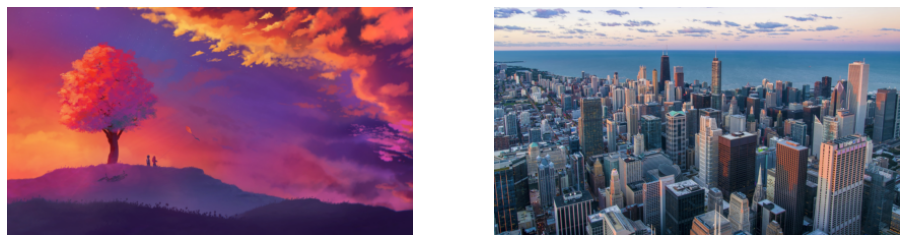

In [63]:
"""
Get the images
"""

styl_ = Image.open("./style.jpg")
cont_ = Image.open("./content.jpeg")

styl = trans(styl_).unsqueeze(0)
cont = trans(cont_).unsqueeze(0)

# Display the images
plt.figure(figsize=(16,9))
splot(toPIL(styl.squeeze()),1,1,2),splot(toPIL(cont.squeeze()),2,1,2)
plt.show()

Photo by [Pedro Lastra](https://unsplash.com/@peterlaster?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText) on [Unsplash](https://unsplash.com/?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText)
Wallpaper

# The network

In [52]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

In [124]:
model = resnet18(pretrained=True)
model = nn.Sequential(*[*model.children()][:-2])

layers = len([*model.children()])

In [143]:
def get_layers(model):
    for m in model.modules():
        if len([*m.children()]) == 0:
            yield m
        
def forward(x, model):
    fp = []
    for child in model.children():
        x = child(x)
        fp.append(x)
    return fp

def styl_matrix(act):
    nc = (torch.tensor(act.size()).prod()*2)
    act = act.squeeze()
    act = act.reshape(act.size(0),-1)
    return (act @ act.T)/nc

In [154]:
"""
The activations for the content and the
style function don't change becuase the model 
parameters don't change hence these can be saved 
and used as required.
"""
act_cont_ = forward(cont, model) 
act_styl_ = forward(styl, model)

# Layer considered for the content
l = 7
# Lambda for the style cost weighting
lamb = torch.linspace(0.1,1,layers)

# Style matrix for the style image for the 8 child layers
styl_gram = [styl_matrix(act) for act in act_styl_]

In [423]:
"""
Cost functions
"""
pairwise = nn.PairwiseDistance()

def content_cost(act, act_cont, l):
    return (act_cont[l].detach() - act[l]).pow(2).sum()/2

def style_cost(act, styl_gram, lamb):
    gene_gram = [styl_matrix(ac) for ac in act]
    inter = [(sg-ss.detach()).pow(2).sum()*l for sg,ss, l in zip(gene_gram,styl_gram,lamb)]
    return torch.tensor(inter,requires_grad=True).sum()

# Considers all style matrices
def loss_function(act, alpha, beta, act_cont=act_cont_, styl_gram=styl_gram, l=l, lamb=lamb):
    cc = content_cost(act, act_cont, l)
    sc = style_cost(act, styl_gram, lamb)
    return alpha * cc + beta * sc


# # Considers style matrix only from layer l
# def loss_function_(act, alpha, beta, act_cont=act_cont_, styl_gram=styl_gram, l=l, lamb=lamb):
#     cc = alpha*pairwise(act[l].reshape(1,-1),act_cont_[l].reshape(1,-1))**2/2
#     sc = beta*pairwise(styl_matrix(act[l]).reshape(1,-1), styl_gram[l].reshape(1,-1))**2/2
#     return cc + sc
    

# Training

In [693]:
from tqdm.autonotebook import tqdm
from copy import deepcopy
from torch.optim import Adam

In [1178]:
"""
Fit function
"""
def fit(e, gene, model,  alpha=alpha, beta=beta):
    l = []
    for i in tqdm(range(e)):
        act = forward(gene, model)
        loss = loss_function(act, alpha, beta)
        l.append(loss.item())
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
    return l

"""
Just trying to fit content image.
"""
def get_model(layer):
    return nn.Sequential(*[*model.children()][:layer])
    
def opt_content_cost(gene=None,losses=None, epoch=1000, layer=1, lr=0.01, alpha=1e-4):
    if gene is None:
        gene = torch.rand(styl.size(),requires_grad=True)
    if losses is None:
        losses = []
        
    optimizer = Adam([gene],lr=lr)
    model = get_model(layer)
    tgt = act_cont_[layer].detach()
    
    pbar = tqdm(total=epoch)
    for i in range(epoch):
        temp = model(gene)
        loss = alpha*(temp - tgt).pow(2).sum()/2
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad() 
        pbar.desc = f"loss: {loss.item():0.4f}"
        pbar.update(1)
        
    return gene, losses

## Testing content cost function

In [1185]:
gene, losses = opt_content_cost(gene, losses, epoch=100, lr=3e-2)

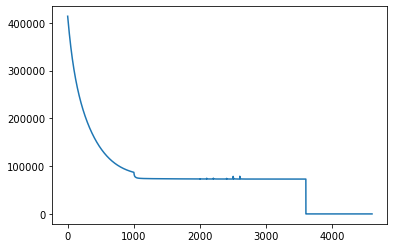

7.2897186279296875


In [1180]:
xax = np.arange(len(losses))
plt.plot(xax, losses)
plt.show()
print(losses[-1])

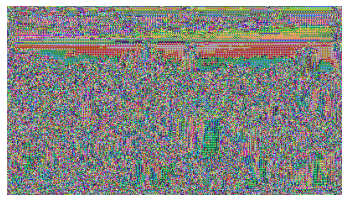

In [1181]:
splot(toPIL(gene.squeeze()))